# Emperical experiment for StreamingCNN

To evaluate whether a neural network using streaming trains equivalently to the conventional training, we can train a CNN on small images using both methods, starting from the same initialization. We used a subset of the ImageNet dataset, [ImageNette](https://github.com/fastai/imagenette), using 100 examples of 10 ImageNet classes (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).

In [1]:
import os
import copy
import random

import torch
import numpy as np
import torchvision
import torchvision.transforms.functional

from PIL import Image
from tqdm import tqdm
from pathlib import Path
from IPython.display import clear_output

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from scnn import StreamingCNN

In [2]:
torch.set_printoptions(precision=10)
torch.manual_seed(0)

In [3]:
# to compare the networks we want to train deterministically
torch.backends.cudnn.deterministic = True

# Download the dataset

In [4]:
if not os.path.isfile('imagenette-320.tgz'):
    !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette-320.tgz
    !tar -xvf imagenette-320.tgz

# Model definition

In [5]:
class StreamNet(torch.nn.Sequential):
    def __init__(self):
        super(StreamNet, self).__init__(
            torch.nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=2), torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

In [6]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), torch.nn.ReLU(inplace=True),
            torch.nn.AdaptiveMaxPool2d(1)
        )

        self.classifier = torch.nn.Linear(256, 10)

    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [7]:
stream_net = StreamNet().cuda()
net = Net().cuda()

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
count_parameters(stream_net) + count_parameters(net)

397098

# Configure streamingSGD

In [ ]:
sCNN = StreamingCNN(stream_net, tile_shape=(1, 3, 160, 160), deterministic=True, verbose=False)


# Create dataloaders

In [11]:
class ImagenetteDataset(object):
    def __init__(self, patch_size=320, validation=False, should_normalize=True):
        self.folder = Path('imagenette-320/train') if not validation else Path('imagenette-320/val')
        self.classes = ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079',
                        'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']

        self.images = []
        for cls in self.classes:
            cls_images = list(self.folder.glob(cls + '/*.JPEG'))
            if validation: self.images += cls_images[0:100]
            else: self.images += cls_images[100:200]
        
        self.patch_size = patch_size
        self.validation = validation
        
        self.random_resize = torchvision.transforms.RandomResizedCrop(patch_size)
        self.center_resize = torchvision.transforms.CenterCrop(patch_size)
        self.should_normalize = should_normalize
        self.normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    def __getitem__(self, index):
        image_fname = self.images[index]
        image = Image.open(image_fname)
        label = image_fname.parent.stem
        label = self.classes.index(label)
        
        if not self.validation: image = self.random_resize(image)
        else: image = self.center_resize(image)
            
        image = torchvision.transforms.functional.to_tensor(image)
        if image.shape[0] == 1: image = image.expand(3, 320, 320)
        if self.should_normalize: image = self.normalize(image)
        
        return image, label

    def __len__(self):
        return len(self.images)

In [12]:
trainset = ImagenetteDataset(320)
valset = ImagenetteDataset(320, validation=True)

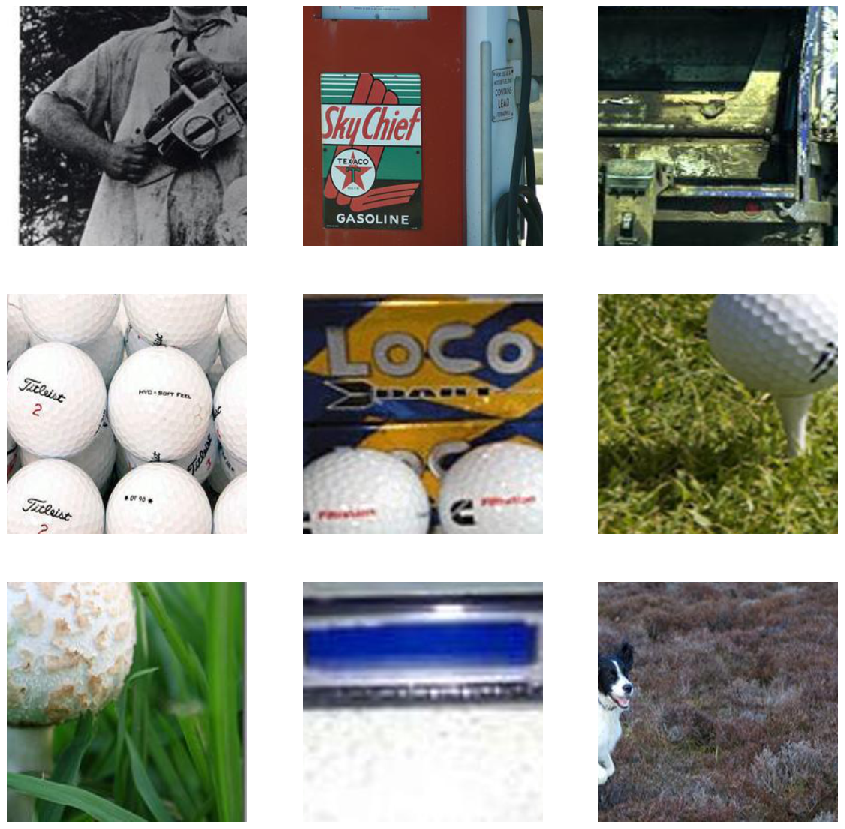

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
visualize_trainset = ImagenetteDataset(320, should_normalize=False)

for y in range(3):
    for x in range(3):
        index = random.randint(0, len(trainset) - 1)
        sample = visualize_trainset[index]
        ax[y, x].imshow(sample[0].numpy().transpose(1,2,0))
        ax[y, x].set_axis_off()

plt.show(); 

# Initialize network and optimizer

In [14]:
for mod in net.modules():
    if isinstance(mod, torch.nn.Conv2d):
        torch.nn.init.kaiming_uniform_(mod.weight)
        mod.bias.data.fill_(0)

In [15]:
# save parameters so that we can start networks from the same initialization
original_initialization_stream_net = copy.deepcopy(stream_net.state_dict())
original_initialization_net = copy.deepcopy(net.state_dict())

In [16]:
params = list(stream_net.parameters()) + list(net.parameters())

In [17]:
criterion = torch.nn.CrossEntropyLoss()

In [18]:
optimizer = torch.optim.SGD(params, lr=1e-3)

In [19]:
batch_size = 4

In [20]:
losses = []
stream_losses = []
stream_val_losses = []
val_losses = []
val_accuracy = []
stream_val_accuracy = []

# Training

In [32]:
def run(epochs=100, streaming=False):
    # sCNN uses hooks to correct gradients while streaming, 
    # so we have to disable it when training conventionally
    if streaming: sCNN.enable()
    else: sCNN.disable()
    
    for epoch in range(epochs):
        running_loss = 0.0
        
        # we train with checkpointing and gradient accumulation,
        # so we need to keep track of the images that will create a batch.
        batch_labels = []
        batch_predictions = []
        batch_images = []

        for data in tqdm(trainloader):
            for image, label in zip(data[0], data[1]):
                # first inference / stream through first network
                with torch.no_grad():
                    if streaming: first_output = sCNN.forward(image)
                    else: first_output = stream_net.forward(image[None].cuda())

                batch_predictions.append(first_output)
                batch_labels.append(label)
                batch_images.append(image)
                
                # gather all predictions as a batch
                if len(batch_predictions) == batch_size:
                    fmap = torch.cat(batch_predictions, 0)
                    fmap.requires_grad = True
                    
                    labels = torch.cuda.LongTensor(batch_labels)

                    # inference final part of network
                    second_output = net(fmap)
                    
                    # backpropagation through final network
                    loss = criterion(second_output, labels)
                    loss.backward()

                    # backpropagation through first network using checkpointing / streaming
                    for i, x in enumerate(batch_images):
                        if streaming: 
                            sCNN.backward(x, fmap.grad[i][None])
                        else:
                            first_output = stream_net.forward(x[None].cuda())
                            first_output.backward(fmap.grad[i][None])

                    optimizer.step()
                    optimizer.zero_grad()
                    
                    # reset batch
                    batch_labels = []
                    batch_predictions = []
                    batch_images = []
                    
                    running_loss += loss.item()
                    
        if streaming: stream_losses.append(running_loss / len(trainloader))
        else: losses.append(running_loss / len(trainloader))

        running_loss = 0
        i = 0
        accurate = 0
        with torch.no_grad():
            for data in valloader:
                for image, label in zip(data[0], data[1]):
                    if streaming: first_output = sCNN.forward(image)
                    else: first_output = stream_net.forward(image[None].cuda())
                    second_output = net(first_output)
                    
                    loss = criterion(second_output, label[None].cuda())
                    running_loss += loss.item()
                    i += 1
                    
                    if torch.argmax(torch.softmax(second_output, dim=1)).cpu() == label: 
                        accurate += 1

        if streaming: stream_val_accuracy.append(accurate / i)
        else: val_accuracy.append(accurate / i)
            
        if streaming: stream_val_losses.append(running_loss / i)
        else: val_losses.append(running_loss /  i)
            
        plot_losses()

def plot_losses():
    clear_output(wait=True)
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
    ax[0].plot(np.arange(len(losses)), losses, label="loss, normal case")
    ax[0].plot(np.arange(len(stream_losses)), stream_losses, label="loss, streaming", color="C1")
    ax[1].plot(np.arange(len(losses)), losses, label="train loss, normal case")
    ax[1].plot(np.arange(len(val_losses)), val_losses, label="validation loss, normal case")
    ax[2].plot(np.arange(len(stream_losses)), stream_losses, label="train loss, streaming", color="C1")
    ax[2].plot(np.arange(len(stream_val_losses)), stream_val_losses, label="train loss, streaming", color="C2")
    ax[3].plot(np.arange(len(val_accuracy)), val_accuracy, label="normal accuracy")
    ax[3].plot(np.arange(len(stream_val_accuracy)), stream_val_accuracy, label="streaming accuracy")
    ax[0].legend() 
    ax[1].legend() 
    ax[2].legend() 
    ax[3].legend()
    plt.show();

## Train conventionally (not streaming)

In [22]:
# load original state
stream_net.load_state_dict(original_initialization_stream_net)
net.load_state_dict(original_initialization_net)

<All keys matched successfully>

In [23]:
# initialize the dataloaders after re-seed, if we do this in both training cases the order is identical
torch.manual_seed(0)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=1)
valloader = torch.utils.data.DataLoader(valset, batch_size=4, shuffle=False, num_workers=1)

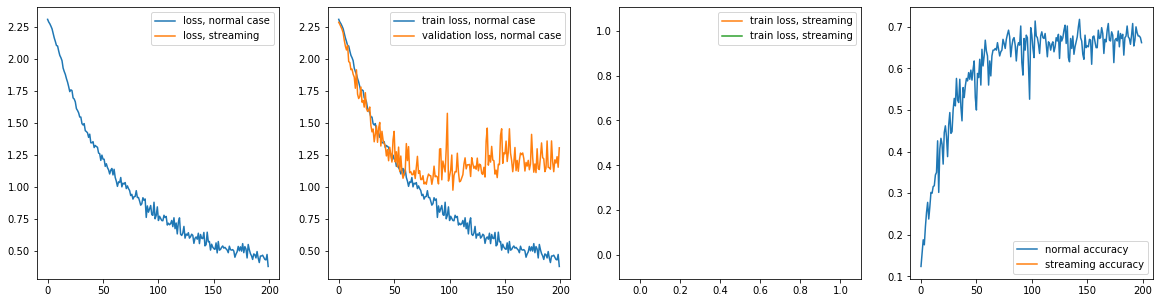

In [24]:
run(epochs=200, streaming=False)

---

## Train streaming

In [33]:
# load original state
stream_net.load_state_dict(original_initialization_stream_net)
net.load_state_dict(original_initialization_net)

<All keys matched successfully>

In [34]:
# initialize the dataloaders after re-seed
torch.manual_seed(0)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=1)
valloader = torch.utils.data.DataLoader(valset, batch_size=4, shuffle=False, num_workers=1)

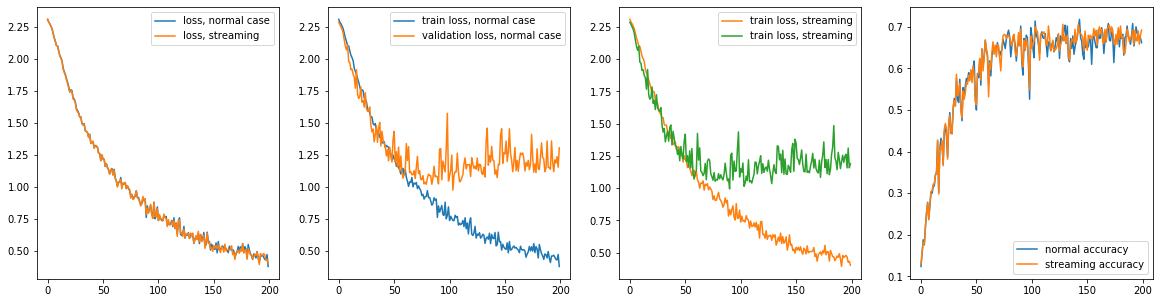

In [36]:
run(epochs=200, streaming=True)

---

# Bonus: LSUV initialization as explained in paper

In [ ]:
from itertools import chain

def data_dependent_init(net, checkpoint_net, dataloader, n_images=20):
    with torch.no_grad():
        for m in chain(net.modules(), checkpoint_net.modules()):
            if isinstance(m, torch.nn.Conv2d):
                if not hasattr(m, 'iteration'):
                    m.running_sum = torch.zeros(m.out_channels).cuda()
                    m.running_sqrs = torch.ones(m.out_channels).cuda()
                    m.iterator = 0

        def init_hook(mod, inpt, outpt):
            dims = (0, 2, 3)
            nc = outpt.shape[1]
            s = outpt.sum(dims, keepdim=False)
            ss = (outpt*outpt).sum(dims, keepdim=False)
            c = outpt.numel() / nc

            mod.running_sum += s
            mod.running_sqrs += ss
            mod.iterator += c

            means = (s / c)
            var = (ss / c) - means**2
            stds = var.sqrt()

            outpt -= means[:, None, None]
            outpt /= (stds[:, None, None] + 1e-10)

        hooks = []
        for mod in chain(net.modules(), checkpoint_net.modules()):
            if isinstance(mod, torch.nn.Conv2d):
                hook = mod.register_forward_hook(init_hook)
                hooks.append(hook)

        # first do forward pass to determine running stds average
        net.eval()
        i = 0
        for x, y in dataloader:
            if i == n_images: break
            for image, label in zip(x, y):
                first_output = checkpoint_net.forward(image[None].cuda())
                second_output = net(first_output)
                i += 1

        # correct weights with running stds average
        for m in chain(net.modules(), checkpoint_net.modules()):
            if isinstance(m, torch.nn.Conv2d):
                mean = (m.running_sum / m.iterator)
                variance = (m.running_sqrs / m.iterator) - mean**2
                stds = variance.sqrt() + 1e-10
                m.weight.data /= stds[:, None, None, None]
                m.bias.data -= mean / stds

        for hook in hooks:
            hook.remove()

In [ ]:
# data_dependent_init(net, stream_net, trainloader)